In [45]:
import requests
import altair as alt
import pandas as pd
from pandas.io.json import json_normalize

from pyvis.network import Network
from ipywidgets import interact, fixed

import re

%load_ext autoreload
%autoreload 2
%cd ../intervals
from main import *
from main_objs import *
import visualizations as viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/dangtrang/OneDrive - brynmawr.edu/summer 2021/crim_intervals/intervals


## ImportedPiece methods tests

### retrieve similarity score

In [155]:
model_8 = 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_3.0/CRIM_Model_0008.mei'
corpus = CorpusBase([model_8])
model = corpus.scores[0]
mel_ngram = model.getNgrams(df=model.getMelodic('z', True, True), n=5)
dur_mel = model.getDuration(df=model.getMelodic('z', True, True), n=5, mask_df=mel_ngram)
score_df = model.getDistance(df=mel_ngram)

Memoized piece detected...


In [156]:
score_df.loc['0, 1, -1, -1, -1'].max()

16

In [159]:
viz.plot_close_match_heatmap(mel_ngram, '0, 1, -1, -1, -1', score_df, dur_mel, selected_patterns=pats, compare='d')

alt.VConcatChart(...)

### retrieve ngrams from EMA

How could each pattern has a different number of other patterns? -- Only account for unique other pattern.

## Relationships heatmaps

In [9]:
df_relationships = pd.read_csv('../CRIM_Intervals_Notebooks/crim_relationships.csv')
files = df_relationships['model_observation.piece.piece_id'].unique()
df_relationships_0011 = df_relationships[df_relationships['model_observation.piece.piece_id'] == files[0]].copy()

In [11]:
df_relationships_0011.head()

,Unnamed: 0,url,id,relationship_type,musical_type,rt_q,rt_q_x,rt_q_monnayage,rt_tm,rt_tm_snd,...,model_observation.piece.url,model_observation.piece.piece_id,model_observation.piece.full_title,model_observation.ema,derivative_observation.url,derivative_observation.id,derivative_observation.piece.url,derivative_observation.piece.piece_id,derivative_observation.piece.full_title,derivative_observation.ema
0,0,http://crimproject.org/data/relationships/1/,1,Quotation,Fuga,True,True,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0011,Tota pulchra es,"1-6/1,1,1-2,1-2,2,2/@1,@1-3,@1-3+@1,@1-3+@1-3,...",http://crimproject.org/data/observations/2/,2,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0009_3,Missa Tota pulchra es: Credo,"1-6/1,1,1+3,1+3,3,3/@1-4,@1-3,@1-3+@1-4,@1-3+@..."
1,1,http://crimproject.org/data/relationships/2/,2,Non-mechanical transformation,Fuga,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0011,Tota pulchra es,"5-9/1,1,1-2,2,2/@3,@1-4,@1-2+@4,@1-4,@1-2",http://crimproject.org/data/observations/4/,4,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0009_3,Missa Tota pulchra es: Credo,"5-8/1,1+4,1+4,4/@3,@1-4+@4,@1+@1-3,@1"
2,2,http://crimproject.org/data/relationships/3/,3,Non-mechanical transformation,Fuga,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0011,Tota pulchra es,"5-9,14-18/1,1,1-2,1-2,1-2,3,3,3-4,3-4,3-4/@3,@...",http://crimproject.org/data/observations/6/,6,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0009_5,Missa Tota pulchra es: Agnus Dei,"9-12/3-4,2-4,2,2/@4+@1-4,@4+@1-4+@1-3,@1-3,@1"
3,3,http://crimproject.org/data/relationships/4/,4,Non-mechanical transformation,Fuga,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0011,Tota pulchra es,"5-9/1,1,1-2,2,2/@3,@1-4,@1-2+@4,@1-4,@1-2",http://crimproject.org/data/observations/8/,8,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0009_3,Missa Tota pulchra es: Credo,"5-10/1,1+4,1+4,1+4,1+4,4/@3,@1-4+@4,@1-4.5+@1-..."
183,183,http://crimproject.org/data/relationships/184/,184,Non-mechanical transformation,Imitative duo,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0011,Tota pulchra es,"1-7,10-16/1,1,1-2,1-2,2,2,2,3,3,3-4,3-4,4,4,4/...",http://crimproject.org/data/observations/368/,368,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0009_3,Missa Tota pulchra es: Credo,"1-6,10-13/1,1,1+3,1+3,3,3,2,2-3,2-3,3/@1-4,@1-..."


In [12]:
df_relationships_0011[df_relationships_0011['relationship_type']== "Quotation, Mechanical transformation"]

,Unnamed: 0,url,id,relationship_type,musical_type,rt_q,rt_q_x,rt_q_monnayage,rt_tm,rt_tm_snd,...,model_observation.piece.url,model_observation.piece.piece_id,model_observation.piece.full_title,model_observation.ema,derivative_observation.url,derivative_observation.id,derivative_observation.piece.url,derivative_observation.piece.piece_id,derivative_observation.piece.full_title,derivative_observation.ema
256,256,http://crimproject.org/data/relationships/258/,258,"Quotation, Mechanical transformation",Fuga,True,False,True,True,True,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0011,Tota pulchra es,"76-77/1+3,1+3/@3-4.5+@4,@1-2+@1-2.5",http://crimproject.org/data/observations/516/,516,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0009_3,Missa Tota pulchra es: Credo,"85-87/1,1-2,2/@4,@1-3+@2-4.5,@1"


In [13]:
df_relationships_0011.iloc[0, :]

Unnamed: 0                                                                                 0
url                                             http://crimproject.org/data/relationships/1/
id                                                                                         1
relationship_type                                                                  Quotation
musical_type                                                                            Fuga
rt_q                                                                                    True
rt_q_x                                                                                  True
rt_q_monnayage                                                                         False
rt_tm                                                                                  False
rt_tm_snd                                                                              False
rt_tm_minv                                                            

In [14]:
viz.plot_comparison_heatmap(df_relationships.loc[:200], 'model_observation.ema', main_category='musical_type', other_category='observer.name', heat_map_width=800,
                              heat_map_height=300)

alt.VConcatChart(...)

In [15]:
#retrieve_notes_and_durations('https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_3.0/CRIM_Model_0011.mei', '1-6/1,1,1-2,1-2,2,2/@1,@1-3,@1-3+@1,@1-3+@1-3,@1-3,@1')

## Observations heatmap

In [3]:
df_observations = pd.read_csv('../CRIM_Intervals_Notebooks/crim_observations.csv')

In [9]:
df_observations[(df_observations['musical_type'] == 'Cadence') & (df_observations['piece.piece_id'] == 'CRIM_Model_0008')]

,Unnamed: 0,url,id,ema,musical_type,mt_cf,mt_cf_voices,mt_cf_dur,mt_cf_mel,mt_sog,...,remarks,created,updated,curated,observer.url,observer.name,piece.url,piece.piece_id,piece.full_title,piece.mass
1967,1967,http://crimproject.org/data/observations/1969/,1969,"50-53/1,1,1+3,1+3/@4,@1.5-4,@1-4+@3,@1+@1",Cadence,False,NaN,False,False,False,...,NaN,2017-07-25T23:31:47-04:00,2020-07-27T08:51:36.733650-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Stephanie Schlagel,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
4631,4631,http://crimproject.org/data/observations/4633/,4633,"23-24/2-3,2-3/@1+@1-4,@1-3+@1-3",Cadence,False,NaN,False,False,False,...,NaN,2017-08-14T18:30:57-04:00,2019-06-26T17:55:31.431000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Peter Schubert,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
4831,4831,http://crimproject.org/data/observations/4833/,4833,"33-35/1-2,1-2,1-2/@4+@4,@1-4+@1-3,@1+@1",Cadence,False,NaN,False,False,False,...,mass cadence has new beginning of phrase,2017-08-16T20:53:54-04:00,2019-06-26T17:55:32.642000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Peter Schubert,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5097,5097,http://crimproject.org/data/observations/5099/,5099,"59-60/1-2,1-3/@2-4+@2-3,@1+@1+@1",Cadence,False,NaN,False,False,False,...,NaN,2019-05-12T05:40:34.942000-04:00,2019-06-26T17:55:34.189000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5099,5099,http://crimproject.org/data/observations/5101/,5101,"64-65/3-4,3-4/@2-4+@2-3,@1+@1",Cadence,False,NaN,False,False,False,...,NaN,2019-05-12T05:44:22.656000-04:00,2019-06-26T17:55:34.201000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5116,5116,http://crimproject.org/data/observations/5118/,5118,"52-53/1+3,1+3/@2-4+@2-3,@1+@1",Cadence,False,NaN,False,False,False,...,NaN,2019-05-14T06:45:07.211000-04:00,2020-07-27T08:58:45.847629-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5143,5143,http://crimproject.org/data/observations/5145/,5145,"52-53/1+3,1+3/@2-4+@3,@1+@1",Cadence,False,NaN,False,False,False,...,NaN,2019-05-14T08:11:30.227000-04:00,2019-06-26T17:55:34.437000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5171,5171,http://crimproject.org/data/observations/5173/,5173,"64-65/3-4,1+3-4/@2-4+@2-3,@1+@1+@1",Cadence,False,NaN,False,False,False,...,NaN,2019-05-14T10:04:37.362000-04:00,2019-06-26T17:55:34.572000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN


In [5]:
OBSERVATIONS_DICT_EXAMPLE = {'Unnamed: 0': {60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89}, 'url': {60: 'http://crimproject.org/data/observations/61/', 61: 'http://crimproject.org/data/observations/62/', 62: 'http://crimproject.org/data/observations/63/', 63: 'http://crimproject.org/data/observations/64/', 64: 'http://crimproject.org/data/observations/65/', 65: 'http://crimproject.org/data/observations/66/', 66: 'http://crimproject.org/data/observations/67/', 67: 'http://crimproject.org/data/observations/68/', 68: 'http://crimproject.org/data/observations/69/', 69: 'http://crimproject.org/data/observations/70/', 70: 'http://crimproject.org/data/observations/71/', 71: 'http://crimproject.org/data/observations/72/', 72: 'http://crimproject.org/data/observations/73/', 73: 'http://crimproject.org/data/observations/74/', 74: 'http://crimproject.org/data/observations/75/', 75: 'http://crimproject.org/data/observations/76/', 76: 'http://crimproject.org/data/observations/77/', 77: 'http://crimproject.org/data/observations/78/', 78: 'http://crimproject.org/data/observations/79/', 79: 'http://crimproject.org/data/observations/80/', 80: 'http://crimproject.org/data/observations/81/', 81: 'http://crimproject.org/data/observations/82/', 82: 'http://crimproject.org/data/observations/83/', 83: 'http://crimproject.org/data/observations/84/', 84: 'http://crimproject.org/data/observations/85/', 85: 'http://crimproject.org/data/observations/86/', 86: 'http://crimproject.org/data/observations/87/', 87: 'http://crimproject.org/data/observations/88/', 88: 'http://crimproject.org/data/observations/89/', 89: 'http://crimproject.org/data/observations/90/'}, 'id': {60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90}, 'ema': {60: '86-89/2,1-2+4,1-2+4,4/@3,@1-4+@1-3+@3,@1-3+@1+@1-3,@1', 61: '148-150/1-2,1-2+5,1+5/@3+@2-4,@1-3+@1-2+@2-4,@1+@1-3', 62: '73-79/5,3+5,3+5-6,3+5-6,3+5-6,3+6,6/@3,@3+@1-3,@1-3+@1+@1-4,@1-3+@1-4+@1-3,@1-3+@1-3+@3,@1+@1-3,@1', 63: '149-152/5,2+5,2+5-6,5-6/@2-4,@2-4+@1-4,@1-3+@1-3+@2-4,@1+@1', 64: '152-155/2-3,2-3,2-3,2-3/@3-4.5+@4,@1-4+@1-4,@1-4+@1-4,@1+@1', 65: '129-132/2,2-3,2-3,2-3/@4,@1-4+@2-4.5,@1-4.5+@1-4.5,@1+@1-3', 66: '40-41/4+6,4+6/@2-4.5+@3-4.5,@1+@1-2', 67: '153-154/2+5-6,2+5-6/@4+@3-4.5+@2-4.5,@1-3+@1-2+@1', 68: '87-88/1,1/@1-4,@1-3', 69: '58-60/1,1,1/@2-4,@1-3,@1', 70: '88-91/3,1-3,1-4,1+4/@3,@3+@1-4+@1-3,@1-3+@1-3+@1+@1-4,@1+@1-3', 71: '57-65/3,1+3-4,1-5,1-5,1+3-6,1-6,2+4-6,4-6,4/@4,@2-4+@1-3+@4,@1-3+@4+@1+@1-3+@1-4,@1@4+@1-3+@2-4+@1-3+@1-3,@1-3+@1-3+@1+@3+@2-4,@1+@2-4.5+@1+@3+@1-3+@1-3,@1+@1-3+@1-3+@2-4,@1-3+@1+@1,@1', 72: '93-98/1,1-3+5-6,1-3+5-6,1-6,1-2+4-6,1-2+4-6/@4,@1-4+@4+@4+@4+@4,@1-3+@1-4.5+@1-3+@1-3+@1-3,@1-3+@1-4+@1+@4+@1@4+@1@4,@1-3+@1-4.5+@1-3+@1-3+@1-3,@1+@1+@1+@1+@1', 73: '64-68/1,1-3+5-6,1-6,3-6,3-6/@1-4.5,@1-4+@2-4+@2-4+@1-4+@2-4,@1+@1+@1-3+@1-4.5+@1-3+@1-3,@2-4+@1-4+@1-4+@1-4,@1+@1+@1+@1', 74: '37-46/2,1-2,1-2,1-2,1-3,1-3,1+3,3,3,3/@3,@1+@1-3,@1-3+@1-3,@1-3+@1-3,@1-3+@1-4+@1,@1-4.5+@1+@1-3,@1-3+@1-3,@1-4,@1-3,@1', 75: '81-88/2,1-3,1-3,1-4,1-4,1-4,1+3-4,4/@1,@1+@1-3+@3,@1-4+@1-3+@1-3,@1-3+@1-4.5+@1-3+@3,@1-4.5+@1@3.5-4+@1-3+@1-3,@1-3+@1+@1-4+@1-3,@1+@1+@1-4.5,@1-3', 76: '39-44/1+5,1+5,1+3+5,3+5,3+5,3/@1-3+@1-3,@1-3+@1-3,@1+@1+@3,@1-3+@1-3,@1-3+@1-3,@1', 77: '82-86/1+6,1+6,1+4+6,4-5,4-5/@1+@1-4,@1-4+@1-3,@1+@3+@1,@1-3+@1-3,@1-3+@1-3', 78: '40-41/4+6,4+6/@2-4.5+@3-4.5,@1+@1-3', 79: '84-85/2+5-6,2+5-6/@2-4.5+@1-4+@4,@1-2+@1+@1-3', 80: '40-41/4+6,4+6/@2-4.5+@3-4.5,@1+@1-3', 81: '86-88/2-3,2+4,2+4/@4+@1-4,@1-3+@2-4.5,@1+@1-3', 82: '1-10/1,1,1,1,1+3,1+3,3,3,3,3/@1,@1,@1,@1,@1+@1,@1+@1,@1,@1,@1,@1', 83: '1-10/1,1,1,1,1+3,1+3,3,3,3,3/@1,@1,@1,@1,@1+@1,@1+@1,@1,@1,@1,@1', 84: '27-38/1,1+4,1+4,1+3-4,1+3-4+6,3+6,2-3+6,2-3+5-6,2+5,2+5,2+5,5/@3,@1-4.5+@3,@1-4.5+@1-4,@1-4.5+@3+@1-3,@1+@1-4.5+@1+@3,@1-4.5+@1-4,@3+@1-4.5+@1-3,@1-4.5+@1+@3+@1,@1-4.5+@1-4,@1-4.5+@1-3,@1+@1,@1', 85: '20-34/3,3+5,3+5,2-3+5,2-3+5-6,2+6,2+6,2-3+6,1+3,1+3,1+3-4,1+3-4+6,4+6,4+6,4/@4,@1-4.5+@3,@1-4.5+@1-4.5,@3+@1-4+@1-3,@1-4.5+@1+@1+@3,@1-4.5+@1-4.5,@1-4+@1-3,@1+@2-3+@1,@1-4+@1-4,@1-4+@1-4,@1-4+@1-3+@2-3,@1-3+@1+@1-4+@1-4,@1-4+@1-4.5,@1-3+@1-3,@1', 86: '27-29/1,1,1/@3,@1-4.5,@1-2', 87: '32-34/2,1-2,1/@2-3,@1-3+@1-2.5,@1-3', 88: '68-70/1+6,1+6,1+6/@2-4+@2-4,@1-4+@1-3,@1+@1', 89: '40-49/2+5,2+4-6,2+4-6,4+6,1+2+4+6,1-2,1-2,1+6,1+6,1+6/@1-4+@1-4,@1-4.5+@3-4.5+@1-3+@3-4,@1+@1-4+@1+@1-4,@1-4+@1,@1-4+@2-4+@1-3+@1,@1-4.5+@1-3,@1-4+@1,@1-4+@1-4,@1-4+@1-3,@1+@1'}, 'musical_type': {60: 'Periodic entry', 61: 'Periodic entry', 62: 'Imitative duo', 63: 'Periodic entry', 64: 'Fuga', 65: 'Fuga', 66: 'Fuga', 67: 'Periodic entry', 68: 'Soggetto', 69: 'Soggetto', 70: 'Periodic entry', 71: 'Periodic entry', 72: 'Homorhythm', 73: 'Fuga, Non-imitative duo', 74: 'Fuga', 75: 'Fuga', 76: 'Non-imitative duo', 77: 'Non-imitative duo', 78: 'Fuga', 79: 'Fuga', 80: 'Fuga', 81: 'Fuga', 82: 'Fuga', 83: 'Fuga', 84: 'Non-imitative duo', 85: 'Non-imitative duo', 86: 'Soggetto', 87: 'Fuga', 88: 'Contrapuntal duo', 89: 'Non-imitative duo'}, 'mt_cf': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_cf_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_cf_dur': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_cf_mel': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_sog': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: True, 69: True, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: True, 87: False, 88: False, 89: False}, 'mt_sog_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: '[Discantus]', 69: 'Discantus', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: '[Discantus]', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_sog_dur': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: True, 69: True, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: True, 87: False, 88: False, 89: False}, 'mt_sog_mel': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: True, 69: True, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: True, 87: False, 88: False, 89: False}, 'mt_sog_ostinato': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_sog_periodic': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_csog': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_csog_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_csog_dur': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_csog_mel': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_cd': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: True, 89: False}, 'mt_cd_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: '[Discantus]\n[Bassus]', 89: 'nan'}, 'mt_fg': {60: False, 61: False, 62: False, 63: False, 64: True, 65: True, 66: True, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: True, 74: True, 75: True, 76: False, 77: False, 78: True, 79: True, 80: True, 81: True, 82: True, 83: True, 84: False, 85: False, 86: False, 87: True, 88: False, 89: False}, 'mt_fg_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'Contratenor [1]\r\nContratenor [2]', 65: 'Contratenor [1]\r\nContratenor [2]', 66: '[QuintaVox]\n[Bassus]', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'Discantus\r\nTenor', 74: '[Contratenor]\n[Discantus]\n[Tenor]', 75: 'Contratenor [1]\r\nDiscantus\r\nContratenor [2]\r\nTenor', 76: 'nan', 77: 'nan', 78: '[QuintaVox]\n[Bassus]', 79: 'Bassus [1]\r\nContratenor\r\nBassus [2]', 80: '[QuintaVox]\n[Bassus]', 81: 'Contratenor [2]\r\nContratenor [1]\r\nTenor', 82: '[Discantus]\n[Tenor]', 83: '[Discantus]\r\n[Contratenor 2]', 84: 'nan', 85: 'nan', 86: 'nan', 87: '[Contratenor 1]\r\n[Discantus]', 88: 'nan', 89: 'nan'}, 'mt_fg_int': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: '1+', 65: '1+', 66: '5-', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: '8-', 74: '4+8-', 75: '4+5-4-', 76: 'nan', 77: 'nan', 78: '5-', 79: '12+12-', 80: '5-', 81: '2+5-', 82: '8-', 83: '8-', 84: 'nan', 85: 'nan', 86: 'nan', 87: '5+', 88: 'nan', 89: 'nan'}, 'mt_fg_tint': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'M1', 65: 'S1', 66: 'M1', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'B2', 74: 'S1/6', 75: 'S2/1/4', 76: 'nan', 77: 'nan', 78: 'M1', 79: 'M1/2', 80: 'M1', 81: 'M3/2', 82: 'B4', 83: 'B4', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'S2', 88: 'nan', 89: 'nan'}, 'mt_fg_periodic': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fg_strict': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: True, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: True, 74: True, 75: False, 76: False, 77: False, 78: True, 79: True, 80: True, 81: True, 82: True, 83: True, 84: False, 85: False, 86: False, 87: True, 88: False, 89: False}, 'mt_fg_flexed': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: True, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fg_sequential': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fg_inverted': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fg_retrograde': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe': {60: True, 61: True, 62: False, 63: True, 64: False, 65: False, 66: False, 67: True, 68: False, 69: False, 70: True, 71: True, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe_voices': {60: '[Contratenor]\n[Discantus]\n[QuintaVox]', 61: 'Contratenor [1]\r\nDiscantus\r\nBassus [1]', 62: 'nan', 63: 'Bassus [1]\r\nContratenor [1]\r\nBassus [2]', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'Bassus [2]\r\nBassus [1]\r\nContratenor', 68: 'nan', 69: 'nan', 70: '[Tenor]\n[Contratenor]\n[Discantus]\n[QuintaVox]', 71: 'Contratenor [2]\r\nDiscantus\r\nTenor \r\nBassus [1]\r\nContratenor [1]\r\nContratenor [2]\r\nDiscantus\r\nBassus [2]\r\nBassus [1]\r\nContratenor [1]\r\nTenor \r\nBassus [2]', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_pe_int': {60: '7+4-', 61: '7+11-', 62: 'nan', 63: '8+8-', 64: 'nan', 65: 'nan', 66: 'nan', 67: '1+8+', 68: 'nan', 69: 'nan', 70: '2+7+4-', 71: '5+8-4-5+3+5+15-5+7+4-8-', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_pe_tint': {60: 'S1/1', 61: 'S1/1', 62: 'nan', 63: 'S2/2', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'M1/1', 68: 'nan', 69: 'nan', 70: 'S1', 71: 'S1/1/1/1/1/1/1/1/1/1/1', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_pe_strict': {60: True, 61: True, 62: False, 63: True, 64: False, 65: False, 66: False, 67: True, 68: False, 69: False, 70: True, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe_flexed': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: True, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe_flt': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe_sequential': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe_added': {60: False, 61: False, 62: False, 63: True, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_pe_invertible': {60: True, 61: True, 62: False, 63: True, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: True, 71: True, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_id': {60: False, 61: False, 62: True, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_id_voices': {60: 'nan', 61: 'nan', 62: '[SextaVox]\n[Tenor]\n[Bassus]\n[SextaVox]\n[Tenor]\n[Bassus]', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_id_int': {60: 'nan', 61: 'nan', 62: '8+4-5-9+5-', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_id_tint': {60: 'nan', 61: 'nan', 62: 'S2/1/2/1/2', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_id_strict': {60: False, 61: False, 62: True, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_id_flexed': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_id_flt': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_id_invertible': {60: False, 61: False, 62: True, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_nid': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: True, 74: False, 75: False, 76: True, 77: True, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: True, 85: True, 86: False, 87: False, 88: False, 89: True}, 'mt_nid_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'Bassus [1]\r\nBassus [2]', 74: 'nan', 75: 'nan', 76: '[Discantus]\r\n[SextaVox]\r\n[Tenor]\r\n[SextaVox]', 77: 'Discantus\r\nBassus [2]\r\nTenor \r\nBassus [1]', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: '[Discantus]\n[QuintaVox]\n[Tenor]\n[Bassus]\n[Contratenor]\n[SextaVox]', 85: '[Contratenor 2]\r\n[Bassus 1]\r\n[Contratenor 1]\r\n[Bassus 2]\r\n[Contratenor 2]\r\n[Discantus]\r\n[Tenor]\r\n[Bassus 2]', 86: 'nan', 87: 'nan', 88: 'nan', 89: '[Contratenor 1]\r\n[Bassus 1]\r\n[Tenor] \r\n[Bassus 2]\r\n[Discantus]\r\n[Contratenor 1]'}, 'mt_nid_int': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: '1+', 74: 'nan', 75: 'nan', 76: '8-', 77: '8-', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: '8-1+', 85: '1+4+4-', 86: 'nan', 87: 'nan', 88: 'nan', 89: '1+8+'}, 'mt_nid_tint': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'B2', 74: 'nan', 75: 'nan', 76: 'S4', 77: 'S5', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'B3/3', 85: 'B3/4/3', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'S3/5'}, 'mt_nid_strict': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: True, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_nid_flexed': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: True, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: True, 86: False, 87: False, 88: False, 89: False}, 'mt_nid_flt': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_nid_sequential': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_nid_invertible': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: True, 86: False, 87: False, 88: False, 89: False}, 'mt_hr': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: True, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_hr_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: '[Discantus]\r\n[Contratenor]\r\n[Tenor]\r\n[QuintaVox]\r\n[SextaVox]\r\n[Bassus]', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_hr_simple': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_hr_staggered': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: True, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_hr_sequential': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_hr_fauxbourdon': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_cad': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_cad_cantizans': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_cad_tenorizans': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_cad_type': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_cad_tone': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_cad_dtv': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_cad_dti': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_int': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_int_voices': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_int_p6': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_int_p3': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_int_c35': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_int_c83': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_int_c65': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fp': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fp_ir': {60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: False, 67: False, 68: False, 69: False, 70: False, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: False, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: False, 85: False, 86: False, 87: False, 88: False, 89: False}, 'mt_fp_range': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'mt_fp_comment': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'nan', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'nan', 77: 'nan', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'nan', 89: 'nan'}, 'remarks': {60: 'nan', 61: 'nan', 62: 'nan', 63: 'Added entry in B1 mes.150-151', 64: 'nan', 65: 'nan', 66: 'nan', 67: 'nan', 68: 'nan', 69: 'nan', 70: 'nan', 71: 'nan', 72: 'nan', 73: 'nan', 74: 'nan', 75: 'nan', 76: 'In second NIM, tenor is 8- but S is 1+', 77: 'NOT FLEXED\r\nIn second NIM, T is 8- but B1 is 1+', 78: 'nan', 79: 'nan', 80: 'nan', 81: 'nan', 82: 'nan', 83: 'nan', 84: 'nan', 85: 'nan', 86: 'nan', 87: 'nan', 88: 'Sogetto in the bass is repeated, creating a module with CS in the contratenor, but the contrapuntal duo DB is not repeated.', 89: 'The lower voice of the NIM is also used as fuga starting in m. 43.'}, 'created': {60: '2017-08-03T19:24:17-04:00', 61: '2017-08-03T19:24:17-04:00', 62: '2017-07-01T00:00:25-04:00', 63: '2017-07-01T00:00:25-04:00', 64: '2017-07-01T01:00:45-04:00', 65: '2017-07-01T01:00:45-04:00', 66: '2017-07-01T01:09:01-04:00', 67: '2017-07-01T01:09:01-04:00', 68: '2017-07-01T01:15:44-04:00', 69: '2017-07-01T01:15:44-04:00', 70: '2017-07-01T01:33:05-04:00', 71: '2017-07-01T01:33:05-04:00', 72: '2017-07-01T01:53:03-04:00', 73: '2017-07-01T01:53:03-04:00', 74: '2017-07-01T17:18:11-04:00', 75: '2017-07-01T17:18:11-04:00', 76: '2017-08-03T19:32:22-04:00', 77: '2017-08-03T19:32:22-04:00', 78: '2017-08-03T19:32:22-04:00', 79: '2017-08-03T19:32:22-04:00', 80: '2017-08-03T19:32:22-04:00', 81: '2017-08-03T19:32:22-04:00', 82: '2017-07-01T17:39:50-04:00', 83: '2017-07-01T17:39:50-04:00', 84: '2017-08-03T19:35:31-04:00', 85: '2017-08-03T19:35:31-04:00', 86: '2017-08-03T19:36:08-04:00', 87: '2017-08-03T19:36:08-04:00', 88: '2017-08-03T19:36:56-04:00', 89: '2017-08-03T19:36:56-04:00'}, 'updated': {60: '2020-08-30T13:42:17.663686-04:00', 61: '2020-08-30T13:42:23.239562-04:00', 62: '2020-08-30T13:43:58.057422-04:00', 63: '2020-08-30T13:44:03.844552-04:00', 64: '2020-07-20T14:59:12.118037-04:00', 65: '2020-07-20T15:00:46.230447-04:00', 66: '2019-06-26T17:55:17.201000-04:00', 67: '2020-07-20T15:02:54.966656-04:00', 68: '2019-06-26T17:55:17.218000-04:00', 69: '2019-06-26T17:55:17.206000-04:00', 70: '2019-06-26T17:55:17.212000-04:00', 71: '2020-07-20T15:07:31.018547-04:00', 72: '2019-06-26T17:55:17.209000-04:00', 73: '2020-07-20T15:26:27.443573-04:00', 74: '2019-06-26T17:55:17.221000-04:00', 75: '2020-07-21T14:00:59.184254-04:00', 76: '2020-08-30T14:14:42.065815-04:00', 77: '2020-07-21T14:01:39.151905-04:00', 78: '2019-06-26T17:55:17.233000-04:00', 79: '2020-07-21T14:07:01.802545-04:00', 80: '2019-06-26T17:55:34.741000-04:00', 81: '2020-07-21T14:07:35.377971-04:00', 82: '2019-06-26T17:55:17.251000-04:00', 83: '2020-07-20T11:45:44.284453-04:00', 84: '2019-06-26T17:55:17.242000-04:00', 85: '2020-08-30T14:29:32.869040-04:00', 86: '2019-06-26T17:55:17.246000-04:00', 87: '2020-07-20T11:49:52.764137-04:00', 88: '2019-06-26T17:55:17.254000-04:00', 89: '2020-08-30T14:39:08.143450-04:00'}, 'curated': {60: True, 61: True, 62: True, 63: True, 64: True, 65: True, 66: True, 67: True, 68: True, 69: True, 70: True, 71: True, 72: True, 73: True, 74: True, 75: True, 76: True, 77: True, 78: True, 79: True, 80: True, 81: True, 82: True, 83: True, 84: True, 85: True, 86: True, 87: True, 88: True, 89: True}, 'observer.url': {60: 'http://crimproject.org/data/people/CRIM_Person_1016/', 61: 'http://crimproject.org/data/people/CRIM_Person_1016/', 62: 'http://crimproject.org/data/people/CRIM_Person_1016/', 63: 'http://crimproject.org/data/people/CRIM_Person_1016/', 64: 'http://crimproject.org/data/people/CRIM_Person_1016/', 65: 'http://crimproject.org/data/people/CRIM_Person_1016/', 66: 'http://crimproject.org/data/people/CRIM_Person_1016/', 67: 'http://crimproject.org/data/people/CRIM_Person_1016/', 68: 'http://crimproject.org/data/people/CRIM_Person_1016/', 69: 'http://crimproject.org/data/people/CRIM_Person_1016/', 70: 'http://crimproject.org/data/people/CRIM_Person_1016/', 71: 'http://crimproject.org/data/people/CRIM_Person_1016/', 72: 'http://crimproject.org/data/people/CRIM_Person_1016/', 73: 'http://crimproject.org/data/people/CRIM_Person_1016/', 74: 'http://crimproject.org/data/people/CRIM_Person_1016/', 75: 'http://crimproject.org/data/people/CRIM_Person_1016/', 76: 'http://crimproject.org/data/people/CRIM_Person_1016/', 77: 'http://crimproject.org/data/people/CRIM_Person_1016/', 78: 'http://crimproject.org/data/people/CRIM_Person_1016/', 79: 'http://crimproject.org/data/people/CRIM_Person_1016/', 80: 'http://crimproject.org/data/people/CRIM_Person_1016/', 81: 'http://crimproject.org/data/people/CRIM_Person_1016/', 82: 'http://crimproject.org/data/people/CRIM_Person_1016/', 83: 'http://crimproject.org/data/people/CRIM_Person_1016/', 84: 'http://crimproject.org/data/people/CRIM_Person_1016/', 85: 'http://crimproject.org/data/people/CRIM_Person_1016/', 86: 'http://crimproject.org/data/people/CRIM_Person_1016/', 87: 'http://crimproject.org/data/people/CRIM_Person_1016/', 88: 'http://crimproject.org/data/people/CRIM_Person_1016/', 89: 'http://crimproject.org/data/people/CRIM_Person_1016/'}, 'observer.name': {60: 'Alexis Risler', 61: 'Alexis Risler', 62: 'Alexis Risler', 63: 'Alexis Risler', 64: 'Alexis Risler', 65: 'Alexis Risler', 66: 'Alexis Risler', 67: 'Alexis Risler', 68: 'Alexis Risler', 69: 'Alexis Risler', 70: 'Alexis Risler', 71: 'Alexis Risler', 72: 'Alexis Risler', 73: 'Alexis Risler', 74: 'Alexis Risler', 75: 'Alexis Risler', 76: 'Alexis Risler', 77: 'Alexis Risler', 78: 'Alexis Risler', 79: 'Alexis Risler', 80: 'Alexis Risler', 81: 'Alexis Risler', 82: 'Alexis Risler', 83: 'Alexis Risler', 84: 'Alexis Risler', 85: 'Alexis Risler', 86: 'Alexis Risler', 87: 'Alexis Risler', 88: 'Alexis Risler', 89: 'Alexis Risler'}, 'piece.url': {60: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 61: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 62: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 63: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 64: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 65: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 66: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 67: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 68: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 69: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 70: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 71: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 72: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 73: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 74: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 75: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 76: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 77: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 78: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 79: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 80: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 81: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_2/', 82: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 83: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_1/', 84: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 85: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_1/', 86: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 87: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_1/', 88: 'http://crimproject.org/data/pieces/CRIM_Model_0017/', 89: 'http://crimproject.org/data/pieces/CRIM_Mass_0015_1/'}, 'piece.piece_id': {60: 'CRIM_Model_0017', 61: 'CRIM_Mass_0015_2', 62: 'CRIM_Model_0017', 63: 'CRIM_Mass_0015_2', 64: 'CRIM_Mass_0015_2', 65: 'CRIM_Mass_0015_2', 66: 'CRIM_Model_0017', 67: 'CRIM_Mass_0015_2', 68: 'CRIM_Model_0017', 69: 'CRIM_Mass_0015_2', 70: 'CRIM_Model_0017', 71: 'CRIM_Mass_0015_2', 72: 'CRIM_Model_0017', 73: 'CRIM_Mass_0015_2', 74: 'CRIM_Model_0017', 75: 'CRIM_Mass_0015_2', 76: 'CRIM_Model_0017', 77: 'CRIM_Mass_0015_2', 78: 'CRIM_Model_0017', 79: 'CRIM_Mass_0015_2', 80: 'CRIM_Model_0017', 81: 'CRIM_Mass_0015_2', 82: 'CRIM_Model_0017', 83: 'CRIM_Mass_0015_1', 84: 'CRIM_Model_0017', 85: 'CRIM_Mass_0015_1', 86: 'CRIM_Model_0017', 87: 'CRIM_Mass_0015_1', 88: 'CRIM_Model_0017', 89: 'CRIM_Mass_0015_1'}, 'piece.full_title': {60: 'Benedicta es', 61: 'Missa Benedicta es: Gloria', 62: 'Benedicta es', 63: 'Missa Benedicta es: Gloria', 64: 'Missa Benedicta es: Gloria', 65: 'Missa Benedicta es: Gloria', 66: 'Benedicta es', 67: 'Missa Benedicta es: Gloria', 68: 'Benedicta es', 69: 'Missa Benedicta es: Gloria', 70: 'Benedicta es', 71: 'Missa Benedicta es: Gloria', 72: 'Benedicta es', 73: 'Missa Benedicta es: Gloria', 74: 'Benedicta es', 75: 'Missa Benedicta es: Gloria', 76: 'Benedicta es', 77: 'Missa Benedicta es: Gloria', 78: 'Benedicta es', 79: 'Missa Benedicta es: Gloria', 80: 'Benedicta es', 81: 'Missa Benedicta es: Gloria', 82: 'Benedicta es', 83: 'Missa Benedicta es: Kyrie', 84: 'Benedicta es', 85: 'Missa Benedicta es: Kyrie', 86: 'Benedicta es', 87: 'Missa Benedicta es: Kyrie', 88: 'Benedicta es', 89: 'Missa Benedicta es: Kyrie'}, 'piece.mass': {60: 'nan', 61: 'CRIM_Mass_0015', 62: 'nan', 63: 'CRIM_Mass_0015', 64: 'CRIM_Mass_0015', 65: 'CRIM_Mass_0015', 66: 'nan', 67: 'CRIM_Mass_0015', 68: 'nan', 69: 'CRIM_Mass_0015', 70: 'nan', 71: 'CRIM_Mass_0015', 72: 'nan', 73: 'CRIM_Mass_0015', 74: 'nan', 75: 'CRIM_Mass_0015', 76: 'nan', 77: 'CRIM_Mass_0015', 78: 'nan', 79: 'CRIM_Mass_0015', 80: 'nan', 81: 'CRIM_Mass_0015', 82: 'nan', 83: 'CRIM_Mass_0015', 84: 'nan', 85: 'CRIM_Mass_0015', 86: 'nan', 87: 'CRIM_Mass_0015', 88: 'nan', 89: 'CRIM_Mass_0015'}}
df_observations2 = pd.DataFrame.from_dict(OBSERVATIONS_DICT_EXAMPLE)
df_observations2

,Unnamed: 0,url,id,ema,musical_type,mt_cf,mt_cf_voices,mt_cf_dur,mt_cf_mel,mt_sog,...,remarks,created,updated,curated,observer.url,observer.name,piece.url,piece.piece_id,piece.full_title,piece.mass
60,60,http://crimproject.org/data/observations/61/,61,"86-89/2,1-2+4,1-2+4,4/@3,@1-4+@1-3+@3,@1-3+@1+...",Periodic entry,False,nan,False,False,False,...,nan,2017-08-03T19:24:17-04:00,2020-08-30T13:42:17.663686-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0017,Benedicta es,nan
61,61,http://crimproject.org/data/observations/62/,62,"148-150/1-2,1-2+5,1+5/@3+@2-4,@1-3+@1-2+@2-4,@...",Periodic entry,False,nan,False,False,False,...,nan,2017-08-03T19:24:17-04:00,2020-08-30T13:42:23.239562-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0015_2,Missa Benedicta es: Gloria,CRIM_Mass_0015
62,62,http://crimproject.org/data/observations/63/,63,"73-79/5,3+5,3+5-6,3+5-6,3+5-6,3+6,6/@3,@3+@1-3...",Imitative duo,False,nan,False,False,False,...,nan,2017-07-01T00:00:25-04:00,2020-08-30T13:43:58.057422-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0017,Benedicta es,nan
63,63,http://crimproject.org/data/observations/64/,64,"149-152/5,2+5,2+5-6,5-6/@2-4,@2-4+@1-4,@1-3+@1...",Periodic entry,False,nan,False,False,False,...,Added entry in B1 mes.150-151,2017-07-01T00:00:25-04:00,2020-08-30T13:44:03.844552-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0015_2,Missa Benedicta es: Gloria,CRIM_Mass_0015
64,64,http://crimproject.org/data/observations/65/,65,"152-155/2-3,2-3,2-3,2-3/@3-4.5+@4,@1-4+@1-4,@1...",Fuga,False,nan,False,False,False,...,nan,2017-07-01T01:00:45-04:00,2020-07-20T14:59:12.118037-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0015_2,Missa Benedicta es: Gloria,CRIM_Mass_0015
65,65,http://crimproject.org/data/observations/66/,66,"129-132/2,2-3,2-3,2-3/@4,@1-4+@2-4.5,@1-4.5+@1...",Fuga,False,nan,False,False,False,...,nan,2017-07-01T01:00:45-04:00,2020-07-20T15:00:46.230447-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0015_2,Missa Benedicta es: Gloria,CRIM_Mass_0015
66,66,http://crimproject.org/data/observations/67/,67,"40-41/4+6,4+6/@2-4.5+@3-4.5,@1+@1-2",Fuga,False,nan,False,False,False,...,nan,2017-07-01T01:09:01-04:00,2019-06-26T17:55:17.201000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0017,Benedicta es,nan
67,67,http://crimproject.org/data/observations/68/,68,"153-154/2+5-6,2+5-6/@4+@3-4.5+@2-4.5,@1-3+@1-2+@1",Periodic entry,False,nan,False,False,False,...,nan,2017-07-01T01:09:01-04:00,2020-07-20T15:02:54.966656-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0015_2,Missa Benedicta es: Gloria,CRIM_Mass_0015
68,68,http://crimproject.org/data/observations/69/,69,"87-88/1,1/@1-4,@1-3",Soggetto,False,nan,False,False,True,...,nan,2017-07-01T01:15:44-04:00,2019-06-26T17:55:17.218000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0017,Benedicta es,nan
69,69,http://crimproject.org/data/observations/70/,70,"58-60/1,1,1/@2-4,@1-3,@1",Soggetto,False,nan,False,False,True,...,nan,2017-07-01T01:15:44-04:00,2019-06-26T17:55:17.206000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Alexis Risler,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0015_2,Missa Benedicta es: Gloria,CRIM_Mass_0015


In [6]:
viz.create_comparisons_networks_and_interactive_df(df_observations2, 'mt_pe_tint', 'time',
                                                                                  'ema')

interactive(children=(Text(value='Input search pattern', description='search_pattern_starts_with'), Output()),…

({'all': <class 'pyvis.network.Network'> |N|=13 |E|=14,
  'S1': <class 'pyvis.network.Network'> |N|=10 |E|=9,
  'nan': <class 'pyvis.network.Network'> |N|=0 |E|=0,
  'S2': <class 'pyvis.network.Network'> |N|=1 |E|=0,
  'M1': <class 'pyvis.network.Network'> |N|=1 |E|=0},
 <function visualizations._manipulate_processed_network_df(df, interval_column, search_pattern_starts_with)>)

In [12]:
viz.plot_comparison_heatmap(df_observations.loc[df_observations['piece.piece_id'] == 'CRIM_Model_0008'], 'ema', main_category='musical_type', other_category='observer.name', heat_map_width=800,
                              heat_map_height=300)

alt.VConcatChart(...)

In [10]:
# df_observations.loc[(df_observations['piece.piece_id'] == 'CRIM_Model_0008')].head(10)
df_observations.loc[(df_observations['piece.piece_id'] == 'CRIM_Model_0008') & (df_observations['musical_type'] == 'Fuga')]
# df_observations.loc[(df_observations['piece.piece_id'] == 'CRIM_Model_0008') & (df_observations['musical_type'] == 'Periodic entry')]['ema'].to_list()

,Unnamed: 0,url,id,ema,musical_type,mt_cf,mt_cf_voices,mt_cf_dur,mt_cf_mel,mt_sog,...,remarks,created,updated,curated,observer.url,observer.name,piece.url,piece.piece_id,piece.full_title,piece.mass
2273,2273,http://crimproject.org/data/observations/2275/,2275,"23-29/2,2,1,1+3,1+3,1+4,4/@1,@1-3,@1,@1-3+@1,@...",Fuga,False,NaN,False,False,False,...,NaN,2017-07-28T01:38:50-04:00,2019-06-26T17:55:23.454000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Stephanie Schlagel,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
2597,2597,http://crimproject.org/data/observations/2599/,2599,"5-10/3-4,3-4,3-4,3-4,3-4,4/@1-3+@all,@1-3+@all...",Fuga,False,NaN,False,False,False,...,NaN,2017-07-30T23:51:16-04:00,2019-10-03T03:32:56.204000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Stephanie Schlagel,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
2835,2835,http://crimproject.org/data/observations/2837/,2837,"95-96,99-100,104-107/2,2,2,2,1+3,1+3,2,2/@1-3....",Fuga,False,NaN,False,False,False,...,NaN,2017-08-03T03:39:11-04:00,2021-02-04T17:09:41.546240-05:00,True,http://crimproject.org/data/people/CRIM_Person...,Stephanie Schlagel,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
4625,4625,http://crimproject.org/data/observations/4627/,4627,"1-4/1-2,1-2,1-2,1-2/@1-3+@all,@1-3+@all,@1-3+@...",Fuga,False,NaN,False,False,False,...,NaN,2017-08-14T18:15:41-04:00,2019-10-27T08:26:31.999000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Peter Schubert,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
4629,4629,http://crimproject.org/data/observations/4631/,4631,"54-56/1-2,1-2,1-2/@3+@3,@1-4+@1-3,@1-3+@1-3",Fuga,False,NaN,False,False,False,...,NaN,2017-08-14T18:26:57-04:00,2019-11-01T16:12:59.022000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Peter Schubert,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
4839,4839,http://crimproject.org/data/observations/4841/,4841,"54-64/1-2,1-4,1-4,1-4,1-4,1-4,1-4,1-4,1-4,1-4,...",Fuga,False,NaN,False,False,False,...,NaN,2017-08-16T21:20:10-04:00,2019-06-26T17:55:36.761000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Peter Schubert,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5113,5113,http://crimproject.org/data/observations/5115/,5115,"44-48/3-4,3-4,3-4,3-4,3-4/@3-4+@4,@1-4+@1-3,@1...",Fuga,False,NaN,False,False,False,...,NaN,2019-05-14T06:00:15.646000-04:00,2019-06-26T17:55:34.424000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5115,5115,http://crimproject.org/data/observations/5117/,5117,"48-50/3-4,3-4,3-4/@2-4+@4,@1-4+@1-3,@1+@1",Fuga,False,NaN,False,False,False,...,Also S/B parallel 10.,2019-05-14T06:45:07.205000-04:00,2019-06-26T17:55:34.294000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5139,5139,http://crimproject.org/data/observations/5141/,5141,"44-50/3-4,3-4,3-4,3-4,3-4,3-4,3-4/@3-4+@4,@1-4...",Fuga,False,NaN,False,False,False,...,Also Superius moves in parallel 10ths with Bas...,2019-05-14T08:06:11.652000-04:00,2019-06-26T17:55:34.421000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN
5141,5141,http://crimproject.org/data/observations/5143/,5143,"44-50/3-4,3-4,3-4,3-4,3-4,3-4,3-4/@3-4+@4,@1-4...",Fuga,False,NaN,False,False,False,...,Also Superius moves in parallel 10ths with Bas...,2019-05-14T08:11:30.203000-04:00,2019-06-26T17:55:34.540000-04:00,True,http://crimproject.org/data/people/CRIM_Person...,Richard Freedman,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,NaN


In [26]:
df_observations_pen = df_observations[df_observations['musical_type']=='Periodic entry'].copy()
df_observations_pen.iloc[0, :]

Unnamed: 0                                                          5
url                       http://crimproject.org/data/observations/6/
id                                                                  6
ema                     9-12/3-4,2-4,2,2/@4+@1-4,@4+@1-4+@1-3,@1-3,@1
musical_type                                           Periodic entry
                                          ...                        
observer.name                                            Drew Ivarson
piece.url           http://crimproject.org/data/pieces/CRIM_Mass_0...
piece.piece_id                                       CRIM_Mass_0009_5
piece.full_title                     Missa Tota pulchra es: Agnus Dei
piece.mass                                             CRIM_Mass_0009
Name: 5, Length: 92, dtype: object

In [27]:
networks, interactive_df = viz.create_comparisons_networks_and_interactive_df(df_observations, 'mt_fg_int', 'melodic', 'ema')

interactive(children=(Text(value='Input search pattern', description='search_pattern_starts_with'), Output()),…

In [28]:
#networks['5-'].show('../CRIM_Intervals_Notebooks/test.html')

## Ngrams heatmaps

In [29]:
mel = model.getMelodic(kind='d', compound=False, unit=0)
mel_ngrams = model.getNgrams(df=mel, n=5)
mel_ngrams_dur = model.getDuration(df=mel, mask_df=mel_ngrams, n=5)
mel_ngrams.head()

,[Superius],Altus,Tenor,Bassus
4.0,"4, 1, 2, 2, -3",NaN,NaN,NaN
20.0,NaN,"4, 1, 2, 2, -3",NaN,NaN
36.0,NaN,NaN,"4, 1, 2, 2, -3",NaN
52.0,NaN,NaN,NaN,"4, 1, 2, 2, -3"
62.0,"-2, -2, -2, 2, -2",NaN,NaN,NaN


### heatmap

In [30]:
dur1 = model.getDuration(df=mel, n=5, mask_df=mel_ngrams)

In [31]:
viz.plot_ngrams_heatmap(mel_ngrams,ngrams_duration=dur1)

alt.VConcatChart(...)

### close match

In [148]:
%%time
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
algorithm = NormalizedLevenshtein()
score_ser = viz.compute_levenshtein_similarity(mel_ngram, algorithm.similarity)

CPU times: user 1.69 s, sys: 7.55 ms, total: 1.69 s
Wall time: 1.69 s


In [149]:
score_ser

pattern           other            
3, 0, 1, 1, -2    3, 0, 1, 1, -2       1.0
                  -1, -1, -1, 1, -1    0.2
                  -1, -1, 1, -1, 3     0.2
                  -1, 1, -1, 3, -1     0.0
                  1, -1, 3, -1, -1     0.0
                                      ... 
-3, 1, -1, -4, 0  0, -2, 1, 1, 0       0.2
                  7, -3, 1, -1, -4     0.6
                  -2, 1, 1, 0, 0       0.4
                  -1, 1, 1, -1, 0      0.4
                  -3, 1, -1, -4, 0     1.0
Name: score, Length: 94249, dtype: float64

In [154]:
viz.plot_close_match_heatmap(mel_ngram, '0, 1, -1, -1, -1', score_ser, dur_mel, selected_patterns=pats, compare='s')

alt.VConcatChart(...)

## Weighted Levenshtein

### compare pair of ngrams

In [36]:
# harmonic
harqtt= model.getHarmonic(kind='d', directed=True, compound=True)
har_ngram = model.getNgrams(df=harqtt, n=5)
har_ngram.stack().value_counts()

# TODO add test for pairs

6, 5, 6, 5, 6       12
6, 6, 6, 6, 6        7
5, 6, 5, 6, 5        7
5, 6, 8, 9, 10       7
6, 8, 7, 6, 5        6
                    ..
3, 3, 3, 1, 3        1
3, 3, 3, 1, 5        1
6, 5, 4, 1, 4        1
6, 5, 3, 4, 4        1
8, 12, 12, 8, 10     1
Length: 767, dtype: int64

### n grams of specific lengths

#### directed ngrams

In [12]:
from strsimpy.weighted_levenshtein import WeightedLevenshtein


def insertion_cost(char):
    return 1.0


def deletion_cost(char):
    return 1.0


def substitution_cost(char_a, char_b):
    return 0.5

wl = WeightedLevenshtein(
    substitution_cost_fn=substitution_cost,
    insertion_cost_fn=insertion_cost,
    deletion_cost_fn=deletion_cost)
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

l = NormalizedLevenshtein()

viz.plot_close_match_levenshtein_heatmap(har_ngram, '6, 5, 4, 1, 4', l, ngrams_duration=dur_har)

alt.VConcatChart(...)

In [46]:
from ObservedPiece import *
# test = ObservedPiece(model_8)
test = ObservedPiece("https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_3.0/CRIM_Model_0017.mei")

Requesting file from https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_3.0/CRIM_Model_0017.mei...
Successfully imported.


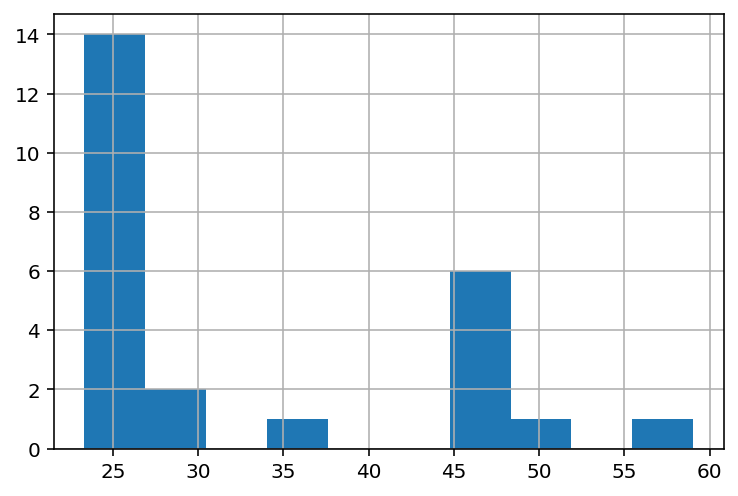

In [51]:
mean_score = []
for selected in PEN:
    res = test.getNgramsFromEma(selected, interval='h')
    scores = viz.plot_close_match_levenshtein_heatmap(res, res.stack().iloc[0], l)
    mean_score.append(scores['score'].mean())
pd.Series(mean_score).hist()

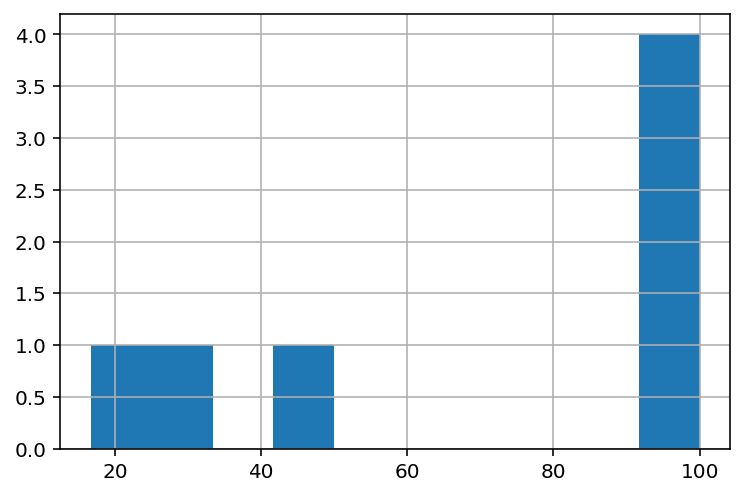

In [50]:
mean_score = []
for selected in FUGA:
    res = test.getNgramsFromEma(selected, interval='h')
    scores = viz.plot_close_match_levenshtein_heatmap(res, res.stack().iloc[0], l)
    mean_score.append(scores['score'].mean())
pd.Series(mean_score).hist()

### ngrams of varied lengths

In [40]:
varied_ngrams = model.getNgrams(df=mel, n=-1)
varied_ngrams_dur = model.getDuration(df=mel, n=-1, mask_df=varied_ngrams)
#viz.plot_close_match_heatmap(varied_ngrams, '2, -3, 1, 1, -2, -2, 2, 2, 2, 2, -2, -2, 1, -2, 2', algorithm=algorithm, ngrams_duration=varied_ngrams_dur)

## Networks for relationships

In [41]:
df_relationships.iloc[26, :]

Unnamed: 0                                                                                26
url                                            http://crimproject.org/data/relationships/27/
id                                                                                        27
relationship_type                                   Quotation, Non-mechanical transformation
musical_type                                                                Counter-soggetto
rt_q                                                                                    True
rt_q_x                                                                                  True
rt_q_monnayage                                                                         False
rt_tm                                                                                  False
rt_tm_snd                                                                              False
rt_tm_minv                                                            

In [11]:
nt = viz.plot_relationship_network(df_relationships, selected_model_ids=['CRIM_Model_0008'], color='derivative')
# %cd ../CRIM_Intervals_Notebooks
nt.show('../CRIM_Intervals_Notebooks/0008.html')

In [14]:
len(nt.edges)

212

In [43]:
df_relationships['model_observation.piece.piece_id'].unique()

array(['CRIM_Model_0011', 'CRIM_Model_0018', 'CRIM_Model_0017',
       'CRIM_Mass_0015_2', 'CRIM_Model_0001', 'CRIM_Model_0020',
       'CRIM_Model_0009', 'CRIM_Model_0019', 'CRIM_Model_0010',
       'CRIM_Model_0022', 'CRIM_Model_0002', 'CRIM_Model_0016',
       'CRIM_Model_0024', 'CRIM_Model_0021', 'CRIM_Mass_0018_1',
       'CRIM_Model_0008', 'CRIM_Mass_0018_3', 'CRIM_Model_0012',
       'CRIM_Model_0023', 'CRIM_Model_0015', 'CRIM_Model_0013',
       'CRIM_Mass_0005_1', 'CRIM_Mass_0016_2', 'CRIM_Mass_0020_3',
       'CRIM_Model_0006', 'CRIM_Model_0025'], dtype=object)

In [44]:
dir(viz)

['Fraction',
 'Network',
 'NormalizedLevenshtein',
 'NormalizedWeightedIntervalLevenshtein',
 'RELATIONSHIP_WEIGHTS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_from_ema_to_offsets',
 '_manipulate_processed_network_df',
 '_plot_ngrams_df_heatmap',
 '_process_crim_json_url',
 '_process_ngrams_df_helper',
 '_trim_and_combine_piece_ids_with_measures',
 'alt',
 'create_bar_chart',
 'create_comparisons_networks_and_interactive_df',
 'create_heatmap',
 'create_interactive_compare_df',
 'create_interval_networks',
 'fixed',
 'generate_ngrams_and_duration',
 'group_observations',
 'interact',
 'pd',
 'plot_close_match_heatmap',
 'plot_comparison_heatmap',
 'plot_ngram_network',
 'plot_ngrams_heatmap',
 'plot_pieces_relationship_network',
 'plot_relationship_network',
 'process_network_df',
 'process_ngrams_df',
 're']

In [45]:
nt2 = viz.plot_relationship_network(df_relationships, selected_derivative_ids=['CRIM_Mass_0017_3', 'CRIM_Mass_0008_4',
       'CRIM_Mass_0003_5', 'CRIM_Mass_0014_4', 'CRIM_Mass_0018_1',
       'CRIM_Mass_0018_2', 'CRIM_Mass_0005_5'], color='derivative')
nt2.show('../CRIM_Intervals_Notebooks/selected_family.html')

In [46]:
nt3 = viz.plot_relationship_network(df_relationships, selected_model_ids = ['CRIM_Model_0002', 'CRIM_Model_0016'], selected_families=['CRIM_Mass_0017_3', 'CRIM_Mass_0008_4',
       'CRIM_Mass_0003_5', 'CRIM_Mass_0014_4', 'CRIM_Mass_0018_1',
       'CRIM_Mass_0018_2', 'CRIM_Mass_0005_5'], color='derivative')
nt3.show('../CRIM_Intervals_Notebooks/selected_model_family.html')

5 CRIM_Mass_0017_3, CRIM_Mass_0008_4, CRIM_Mass_0018_1, CRIM_Mass_0018_2, CRIM_Mass_0005_5 no longer exist in df because of other filtering options


In [47]:
nt4 = viz.plot_relationship_network(df_relationships, selected_model_ids = ['CRIM_Model_0002', 'CRIM_Model_0016'], color='derivative')
nt4.show('../CRIM_Intervals_Notebooks/selected_model.html')

In [48]:
nt3 = viz.plot_relationship_network(df_relationships, selected_model_ids = ['CRIM_Model_0002'], selected_derivative_ids=['CRIM_Mass_0003_5', 'CRIM_Mass_0014'], selected_families=['CRIM_Mass_0017_3', 'CRIM_Mass_0008_4',
       'CRIM_Mass_0003_5', 'CRIM_Mass_0014_4', 'CRIM_Mass_0018_1',
       'CRIM_Mass_0018_2', 'CRIM_Mass_0005_5'], color='derivative')
nt3.show('../CRIM_Intervals_Notebooks/selected_model_deriv_family.html')

6 CRIM_Mass_0017_3, CRIM_Mass_0008_4, CRIM_Mass_0014_4, CRIM_Mass_0018_1, CRIM_Mass_0018_2, CRIM_Mass_0005_5 no longer exist in df because of other filtering options


## Observations network

In [49]:
df_observations.columns

Index(['Unnamed: 0', 'url', 'id', 'ema', 'musical_type', 'mt_cf',
       'mt_cf_voices', 'mt_cf_dur', 'mt_cf_mel', 'mt_sog', 'mt_sog_voices',
       'mt_sog_dur', 'mt_sog_mel', 'mt_sog_ostinato', 'mt_sog_periodic',
       'mt_csog', 'mt_csog_voices', 'mt_csog_dur', 'mt_csog_mel', 'mt_cd',
       'mt_cd_voices', 'mt_fg', 'mt_fg_voices', 'mt_fg_int', 'mt_fg_tint',
       'mt_fg_periodic', 'mt_fg_strict', 'mt_fg_flexed', 'mt_fg_sequential',
       'mt_fg_inverted', 'mt_fg_retrograde', 'mt_pe', 'mt_pe_voices',
       'mt_pe_int', 'mt_pe_tint', 'mt_pe_strict', 'mt_pe_flexed', 'mt_pe_flt',
       'mt_pe_sequential', 'mt_pe_added', 'mt_pe_invertible', 'mt_id',
       'mt_id_voices', 'mt_id_int', 'mt_id_tint', 'mt_id_strict',
       'mt_id_flexed', 'mt_id_flt', 'mt_id_invertible', 'mt_nid',
       'mt_nid_voices', 'mt_nid_int', 'mt_nid_tint', 'mt_nid_strict',
       'mt_nid_flexed', 'mt_nid_flt', 'mt_nid_sequential', 'mt_nid_invertible',
       'mt_hr', 'mt_hr_voices', 'mt_hr_simple', 'mt_hr_s

In [50]:
#process df
df = df_observations[df_observations['piece.piece_id'] == 'CRIM_Model_0008']
df = df[['ema', 'piece.piece_id',
        'musical_type']]
df['ema'] = df['ema'].str.split("/", n=1, expand=True)[0]
df['piece_part'] = df['piece.piece_id'] + ":" + df['ema']
df

,ema,piece.piece_id,musical_type,piece_part
1761,54-65,CRIM_Model_0008,Imitative duo,CRIM_Model_0008:54-65
1763,1-10,CRIM_Model_0008,Periodic entry,CRIM_Model_0008:1-10
1961,1,CRIM_Model_0008,NaN,CRIM_Model_0008:1
1963,44-46,CRIM_Model_0008,Soggetto,CRIM_Model_0008:44-46
1965,46-48,CRIM_Model_0008,"Fuga, Interval patterns",CRIM_Model_0008:46-48
...,...,...,...,...
5185,40-44,CRIM_Model_0008,Homorhythm,CRIM_Model_0008:40-44
5187,94-110,CRIM_Model_0008,Soggetto,CRIM_Model_0008:94-110
5189,44-48,CRIM_Model_0008,Fuga,CRIM_Model_0008:44-48
5214,1,CRIM_Model_0008,Cantus firmus,CRIM_Model_0008:1


In [51]:
# piece being center, nodes == piece part, musical color = musical type
nt = Network(directed=True, notebook=True)
nt.add_nodes(df['piece.piece_id'])

for index in df['piece_part'].index:
    nt.add_node(df['piece_part'].loc[index], group=df['musical_type'].loc[index])
    
for row in df.index:
    nt.add_edge(df['piece.piece_id'].loc[row], df['piece_part'].loc[row],
                 title=df['musical_type'].loc[row])
    
    
nt.inherit_edge_colors("to")
nt.force_atlas_2based()
nt.show('../CRIM_Intervals_Notebooks/piece_network.html')

## Networks of pieces

In [52]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

df = viz._trim_and_combine_piece_ids_with_measures(df_relationships)

# add the nodes and edges into graphs
G = nx.MultiGraph()
G.add_nodes_from(df['model_observation.piece.piece_id'])
G.add_nodes_from(df['derivative_observation.piece.piece_id'])

for row in df.index:
    G.add_edge(df['model_observation.piece.piece_id'].loc[row], 
              df['derivative_observation.piece.piece_id'].loc[row])

# compute the best partition
partition = community_louvain.best_partition(G)

for node in partition:
    G.nodes[node]['group'] = partition[node]

#convert to pyvis
nt = Network(notebook=True)
nt.from_nx(G)
nt.show('../CRIM_Intervals_Notebooks/community.html')